# <center>Analysis of relationship between CPU price and benchmark result</center>
<center>Radosław Suliński</center>

# Introduction

The problem being approached in the project is formulation of a model describing the relationship between price of a CPU and the result of a benchmark, which can in a sense be considered a proxy for quality of the processor.

The main reason to create this model is plain curiosty - one interesting question could be how the value of benchmark score that a single dollar can buy changes with overall price - does it become more or less efficient to increase the budget as price grows, or maybe it doesn't really change?

A few possible, but admittedly a bit unrealistic, use cases for the model are:
* To say how economic is a given CPU - is it over or underpriced
* To decide at what price we can start looking for a certain quality of CPU

# The data

The dataset used in the project comes from the kaggle webiste:
https://www.kaggle.com/datasets/alanjo/cpu-benchmarks

Tt contains data detailing the price and the benchmark result of PassMark. The PassMark benchmark assigns score as an average result of eight different tests ran on the CPU.
Other data columns are ignored, although they do contain interesting information, which can be seen in a table below.

The data is subjected to only very simple preprocessing - sorting it by price and discarding the CPUs with price less than 400$.
The sorting is done, because it results in neater plots when presenting the data.
Cutting off the cheaper CPUs has a more interesting reason - it seems that in the discarded range the data has a different shape than the rest of the dataset. One reason for this could be that this class of cheapest CPUs contain a few categories for which a different model should be used - for example ARM CPUs in microcontroller might have different priorities - power usage is much more important than in PCs and servers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
from cmdstanpy import CmdStanModel

In [2]:
data = pd.read_csv('CPUs.csv', delimiter=';')
data = data.sort_values('price')

Here the data structure can be seen, in the project only 'price' and 'cpuMark' columns are used

In [3]:
data.head(5)

,cpuName,price,cpuMark,cpuValue,threadMark,threadValue,TDP,powerPerf,cores,testDate,socket,category
37,AMD A6-3410MX APU,3.99,1199,300.60,722,180.84,45.0,26.65,4,2011,FS1,Laptop
361,AMD Phenom II N620 Dual-Core,3.99,990,248.09,1069,267.82,35.0,28.28,2,2010,S1,Laptop
204,AMD E2-3200 APU,7.99,953,119.23,964,120.61,65.0,14.66,2,2011,FM1,Desktop
1430,Intel Xeon 2.40GHz,9.10,180,19.73,387,42.52,NaN,NaN,1,2009,unknown,Server
1504,Intel Xeon E3113 @ 3.00GHz,9.79,1429,145.96,1282,130.96,65.0,21.98,2,2014,LGA775,Server


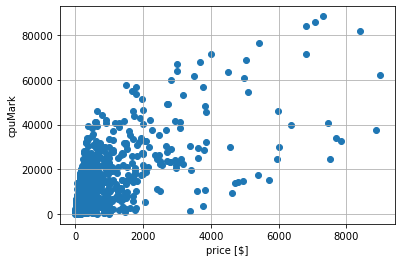

In [4]:
plt.scatter(data['price'], data['cpuMark'])
plt.grid()
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.show()

In the below plot it can be seen that for price less than 400$, the data seems to be different than the rest of the data set.

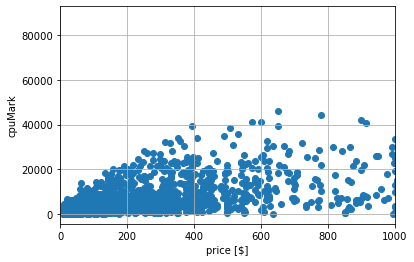

In [5]:
plt.scatter(data['price'], data['cpuMark'])
plt.grid()
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.xlim([0, 1000])
plt.show()

Here the lower range is cut off

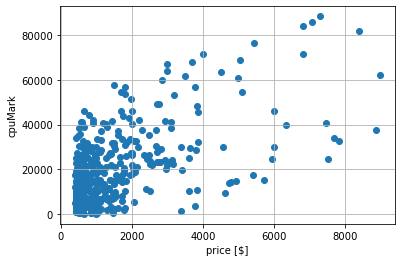

In [6]:
data = data[data['price'] >= 400]
plt.scatter(data['price'], data['cpuMark'])
plt.grid()
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.show()

# Model

The two proposed models are:
* linear: $ score(price) = normal(\alpha +\beta*price, \sigma)$
* quadratic with 0 score at 0 price: $score(price) = normal(\beta*price + \gamma*price^2, \sigma)$

Both of them use only price as input data

The linear model assumes that a simple relationship exists - every dollar adds $\beta$ score on average. The non-zero $\alpha$ allows us more freedom in finding the function, but it suffers from a small problem - ideally the model should have $\mu = 0$ for zero price - after all it makes sense that we don't have a CPU if we don't pay anything. The problem is classified as a small one, because it seems that the model already will not be valid under the price of 400$.

The quadratic model is more complex - the parameter $\gamma$ allows for changes in value of a single dollar depending on the overall price. Additionally no free element $\alpha$ has been used in this model - this is done so that $\mu = 0$ will be true.

# Priors

For the linear model the priors were selected by observing the data and proposing the values based on rough estimations. This is somewhat incorrect because it causes the prior to be based on data, which shouldn't be the case, but the author did not really have any quantifiable prior beliefs about this particular data, since it is quite specific to the benchmark that was used.
- $\alpha = normal(9500, 500)$
- $\beta = normal(6.5, 0.5)$
- $\sigma = normal(12000, 500)$

For the quadratic model a similar approach was used, with one exception - the parameter $\gamma$. In this case the prior was set as a negative value, close to zero. This was done because of the following reasons:
- Negative value of $\gamma$ is needed cause the function to flatten in the considered range.
- The small magnitude of the value was chosen, to make sure that the maximum of the quadratic function is outside of the considered range - there is no expectation that at some point the score start reducing with price.

The actual values of the priors for quadratic function were:
- $\beta = normal(10, 0.3)$
- $\sigma = normal(12000, 500)$
- $\gamma = normal(-0.0004, 0.00004)$


In [7]:
simulation_prices = np.linspace(0, 10000, 1000) # We are considering price up t0 10k$
simulation_data = {'N': len(simulation_prices), 'price': simulation_prices}
R = 1000

Here we are generating data for the linear model

In [8]:
with open('project_generate.stan') as file:
    print(file.read())

data {
	int N;
	real price[N];
}

generated quantities {
	real alpha = normal_rng(9500, 500);
	real beta = normal_rng(6.5, 0.5);
	real sigma = normal_rng(12000, 500);
	real score[N];
	for (i in 1:N){
		score[i] = normal_rng(price[i]*beta+alpha, sigma);
	}
}


In [9]:
generation_model = CmdStanModel(stan_file='project_generate.stan')
sim = generation_model.sample(data=simulation_data, iter_sampling=R, refresh=R, iter_warmup=0, chains=1, fixed_param=True)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


# Prior predictive checks for linear model
The generated linear models seem to make sense. The only visible problem is that the model allows negative values at lower prices because of high value of $\sigma$ - this values should be discared, as the benchmark score cannot be negative.

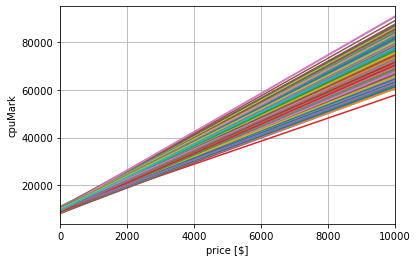

max:  131997.0
min:  -42411.7


In [34]:
x_lim = np.array([0, 10000])
for alpha, beta in zip(sim.stan_variable('alpha'), sim.stan_variable('beta')):
    x = np.array([0, 10000])
    y = alpha + beta * x_lim
    plt.plot(x, y)
plt.xlim([0, 10000])
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.grid()
plt.show()

print('max: ', np.max(sim.stan_variable('score')))
print('min: ', np.min(sim.stan_variable('score')))

The parameter values are sensible as all of them are positive

max:  131997.0
min:  -42411.7


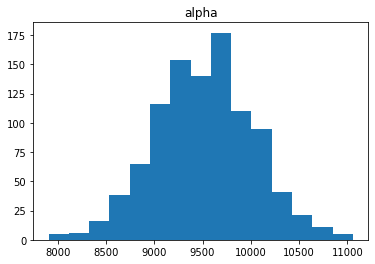

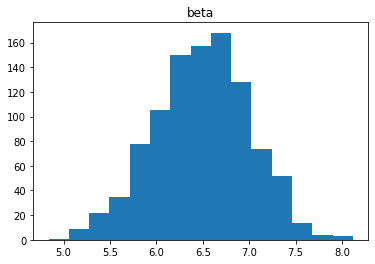

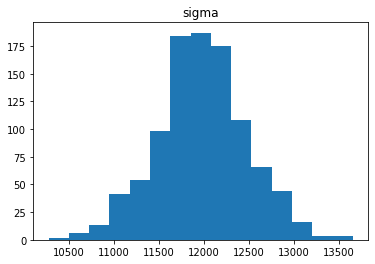

In [11]:
for var in ['alpha', 'beta', 'sigma']:
    plt.hist(sim.stan_variable(var), bins=15)
    plt.title(var)
    plt.show()

In [10]:
sim.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.00,0.0,0.0,0.0,NaN,NaN,NaN
alpha,9500.0,16.000,500.00,8700.0,9500.0,10000.0,1000.0,770.0,1.0
beta,6.5,0.016,0.49,5.7,6.6,7.4,960.0,720.0,1.0
sigma,12000.0,17.000,510.00,11000.0,12000.0,13000.0,940.0,710.0,1.0
score[1],9301.0,373.000,11642.00,-10004.0,8972.0,28664.0,975.0,740.0,1.0
...,...,...,...,...,...,...,...,...,...
score[996],74083.0,393.000,12808.00,52434.0,74227.0,94388.0,1064.0,807.0,1.0
score[997],74808.0,408.000,12789.00,53004.0,75272.0,95222.0,985.0,747.0,1.0
score[998],74365.0,413.000,12712.00,54767.0,74668.0,95852.0,948.0,719.0,1.0


In [37]:
def plot_quantiles(beta, x_arr):
    maximum = []
    minimum = []
    q5 = []
    q25 = []
    q50 = []
    q75 = []
    q95 = []
    quantiles = [q5, q25, q50, q75, q95]
    quantile_levels = [0.05, 0.25, 0.5, 0.75, 0.95]
    for i in range(beta.shape[-1]):
        current_beta = beta[:, i]
        maximum.append(np.max(current_beta))
        minimum.append(np.min(current_beta))
        for quantile, level in zip(quantiles, quantile_levels):
            quantile.append(np.quantile(current_beta, level))
    plt.plot(x_arr, maximum, label='minimum')
    plt.plot(x_arr, minimum, label='maximum')
    for index, quantile in enumerate(quantiles):
        plt.plot(x_arr, quantile, label=f'quantile {quantile_levels[index]}')
    plt.legend()

The measurements from generated data are capturing the real data well - no datapoints are outside of the minimum and maximum, it's not easy to visually judge the other quantiles, but it seems that they line up with real data as well. The only observation here is again the negative values.

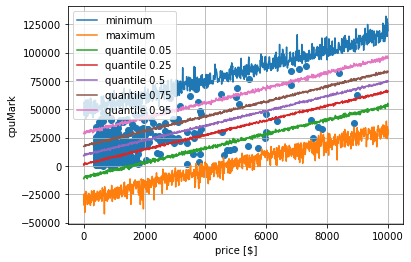

In [39]:
plot_quantiles(sim.stan_variable('score'), simulation_prices)
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.scatter(data['price'], data['cpuMark'])
plt.grid()

# Prior predictive checks for quadratic model

Here again the generated curves seem sensible. One possible improvement could be to make the $\gamma$ value a little bit closer to zero, or to reduce the standard deviation for it. This is because one or two of the curves seem to have a maximum in the considered range, but given that one thousand curves were generated and this happened for just one or two, the prior was still accepted.

In [14]:
with open('project_generate_square.stan') as file:
    print(file.read())

data {
	int N;
	real price[N];
}

generated quantities {
	real beta = normal_rng(10, 0.3);
	real sigma = normal_rng(12000, 500);
	real gamma = normal_rng(-0.0004, 0.00004);
	real score[N];
	for (i in 1:N){
		score[i] = normal_rng(price[i]*price[i]*gamma + price[i]*beta, sigma);
	}
}


In [15]:
generation_model_sq = CmdStanModel(stan_file='project_generate_square.stan')
sim_sq = generation_model_sq.sample(data=simulation_data, iter_sampling=R, refresh=R, iter_warmup=0, chains=1, fixed_param=True)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


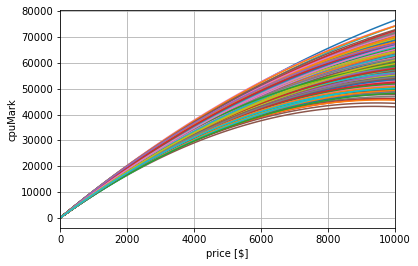

max:  126708.0
min:  -54457.4


In [40]:
x_lim = np.array([0, 10000])
for beta, gamma in zip(sim_sq.stan_variable('beta'), sim_sq.stan_variable('gamma')):
    x = np.linspace(0, 10000, 100)
    y = beta * x + gamma * np.square(x)
    plt.plot(x, y)
plt.xlim([0, 10000])
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.grid()
plt.show()

print('max: ', np.max(sim_sq.stan_variable('score')))
print('min: ', np.min(sim_sq.stan_variable('score')))

Nothing surprising with the parameters

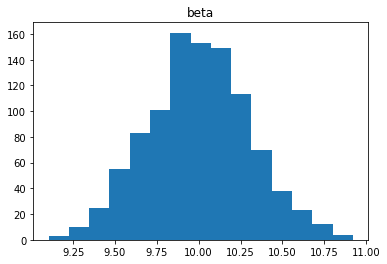

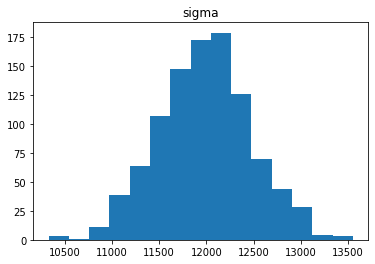

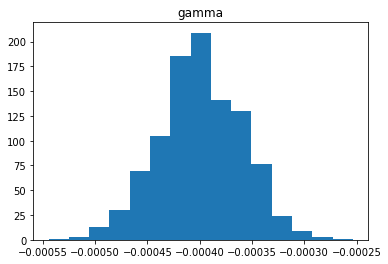

In [17]:
for var in ['beta', 'sigma', 'gamma']:
    plt.hist(sim_sq.stan_variable(var), bins=15)
    plt.title(var)
    plt.show()

In [27]:
sim_sq.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0000,NaN,0.00000,0.00000,0.0000,0.00000,NaN,NaN,NaN
beta,10.0000,0.009600,0.31000,9.50000,10.0000,11.00000,1000.0,780.0,1.0
sigma,12000.0000,16.000000,500.00000,11000.00000,12000.0000,13000.00000,1000.0,770.0,1.0
gamma,-0.0004,0.000001,0.00004,-0.00046,-0.0004,-0.00034,940.0,700.0,1.0
score[1],36.0000,365.000000,12002.00000,-19396.00000,295.0000,19199.00000,1084.0,806.0,1.0
...,...,...,...,...,...,...,...,...,...
score[996],59823.0000,390.000000,12481.00000,38774.00000,59531.0000,79434.00000,1023.0,761.0,1.0
score[997],59019.0000,423.000000,13269.00000,37368.00000,59063.0000,81741.00000,985.0,732.0,1.0
score[998],60201.0000,419.000000,12720.00000,38980.00000,60231.0000,81143.00000,924.0,687.0,1.0


Here similarily, the real data seems to be well captured by the priors.

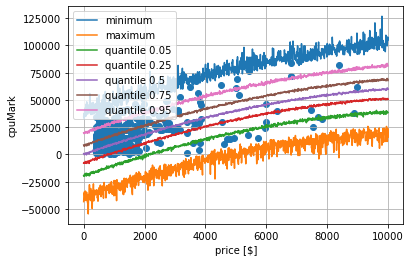

In [41]:
plot_quantiles(sim_sq.stan_variable('score'), simulation_prices)
plt.scatter(data['price'], data['cpuMark'])
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.grid()

# Posterior analysis for linear model
The posterior curves are very similar to the prior, but more closely grouped. This seems to be a good sign - the model was refined.

There were also no issues with the sampling to be resolved.

In [19]:
with open('project_linear_fit.stan') as file:
    print(file.read())

data {
	int N;
	vector[N] price;
	real scores[N];
}

parameters {
	real alpha;
	real beta;
	real<lower=0> sigma;
}

transformed parameters {
	vector[N] mu = price*beta+alpha;
}

model {
	alpha ~ normal(9500, 500);
	beta ~ normal(6.5, 0.5);
	sigma ~ normal(12000, 500);
	scores ~ normal(mu, sigma);
}

generated quantities {
	real score[N];
	vector[N] log_lik;
	array[N] real y_hat;
	for (i in 1:N){
		score[i] = normal_rng(mu[i], sigma);
		log_lik[i] = normal_lpdf(scores[i] | mu[i], sigma);
		y_hat[i] = normal_rng(mu[i], sigma);
	}
}


In [20]:
data_fit = {'N': len(data), 'price': data['price'], 'scores': data['cpuMark']}
model_linear=CmdStanModel(stan_file='project_linear_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


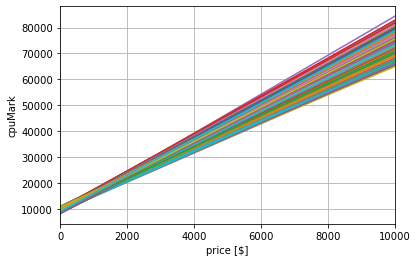

max:  112628.0
min:  -43207.4


In [43]:
fit=model_linear.sample(data=data_fit)
x_lim = np.array([0, 10000])
for alpha, beta in zip(fit.stan_variable('alpha'), fit.stan_variable('beta')):
    x = np.linspace(0, 10000, 100)
    y = alpha + beta * x
    plt.plot(x, y)
plt.xlim([0, 10000])
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.grid()
plt.show()

print('max: ', np.max(fit.stan_variable('score')))
print('min: ', np.min(fit.stan_variable('score')))

The parameters are mostly similar to the one for prior generation. One exception is beta, which is perhaps the most interesting parameter. In the posterior the $\mu$ for $\beta$ is noticeably smaller than in the prior.

The values of the parameters behave like normal distributions.

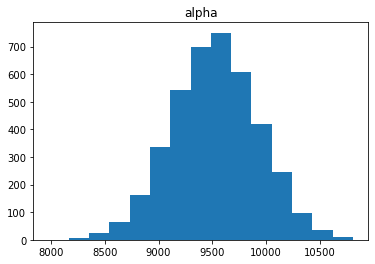

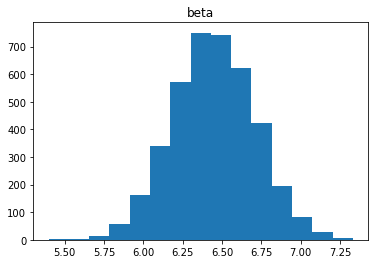

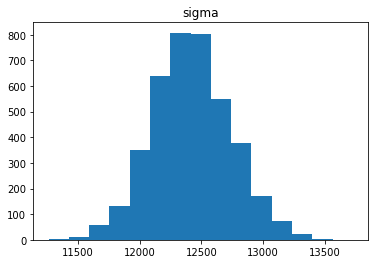

In [22]:
for var in ['alpha', 'beta', 'sigma']:
    plt.hist(fit.stan_variable(var), bins=15)
    plt.title(var)
    plt.show()

In [32]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-4700.0,0.0270,1.20,-4700.0,-4700.0,-4700.0,1900.0,150.0,1.0
alpha,9500.0,7.3000,410.00,8800.0,9500.0,10000.0,3100.0,240.0,1.0
beta,6.5,0.0049,0.26,6.0,6.5,6.9,2900.0,230.0,1.0
sigma,12000.0,5.4000,300.00,12000.0,12000.0,13000.0,3200.0,250.0,1.0
mu[1],12126.0,6.3000,380.00,11489.0,12130.0,12743.0,3642.0,282.0,1.0
...,...,...,...,...,...,...,...,...,...
y_hat[469],58957.0,201.0000,12583.00,37732.0,59103.0,79124.0,3909.0,302.0,1.0
y_hat[470],59873.0,193.0000,12347.00,39256.0,59848.0,80318.0,4075.0,315.0,1.0
y_hat[471],63752.0,204.0000,12773.00,43177.0,63612.0,84954.0,3925.0,304.0,1.0


Here it can be seen that the posterior is also in line with real data.

[]

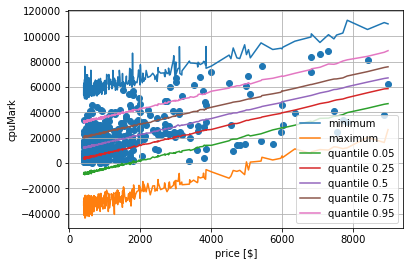

In [45]:
plot_quantiles(fit.stan_variable('score'), data['price'])
plt.grid()
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.scatter(data['price'], data['cpuMark'])
plt.plot()

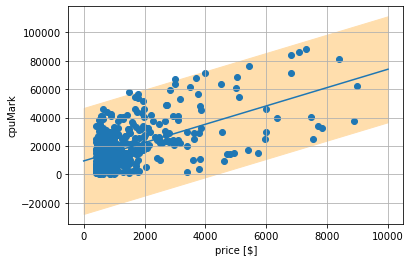

In [46]:
x_lim = np.array([0, 10000])
beta = np.mean(fit.stan_variable('beta'))
alpha = np.mean(fit.stan_variable('alpha'))
sigma = np.mean(fit.stan_variable('sigma'))
x = np.linspace(0, 10000, 100)
y = alpha + beta * x
plt.plot(x, y)
plt.fill_between(x, y+3*sigma, y-3*sigma, color='navajowhite')
plt.grid()
plt.scatter(data['price'], data['cpuMark'])
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.show()

# Posterior analysis for quadratic model

Here the observations are similar as for the linear model, the posterior curves are more tightly grouped than the prior.

In this case there originally were sampling issues. The sampling took a lot of time and the output curves were completely nonsensical - they reached values around $10^7$. This was because the $\gamma$ parameter was not bound to be negative in the stan code. After adding the <upper=0>, everything works fine.


In [25]:
with open('project_square_fit.stan') as file:
    print(file.read())

data {
	int N;
	vector[N] price;
	real scores[N];
}

parameters {
	real beta;
	real<upper=0> gamma;
	real<lower=0> sigma;
}

transformed parameters {
	vector[N] mu = square(price)*gamma+price*beta;
}

model {
	beta ~ normal(10, 0.3);
	sigma ~ normal(12000, 500);
	gamma ~ normal(-0.0004, 0.00004);
	scores ~ normal(mu, sigma);
}

generated quantities {
	real score[N];
	vector[N] log_lik;
	array[N] real y_hat;
	for (i in 1:N){
		score[i] = normal_rng(mu[i], sigma);
		log_lik[i] = normal_lpdf(scores[i] | mu[i], sigma);
		y_hat[i] = normal_rng(mu[i], sigma);
	}
}


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


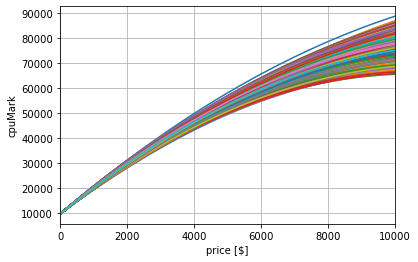

max:  128131.0
min:  -57482.4


In [47]:
model_square=CmdStanModel(stan_file='project_square_fit.stan')
fit_sq=model_square.sample(data=data_fit)
x_lim = np.array([0, 10000])
for beta, gamma in zip(fit_sq.stan_variable('beta'), fit_sq.stan_variable('gamma')):
    x = np.linspace(0, 10000, 100)
    y = alpha + beta * x + gamma * np.square(x)
    plt.plot(x, y)
plt.xlim([0, 10000])
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.grid()
plt.show()

print('max: ', np.max(fit_sq.stan_variable('score')))
print('min: ', np.min(fit_sq.stan_variable('score')))

For all the parameters we observe that the mean has been shifted and that the standard deviation has been reduced comparing to the prior.

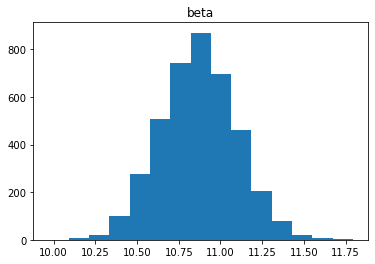

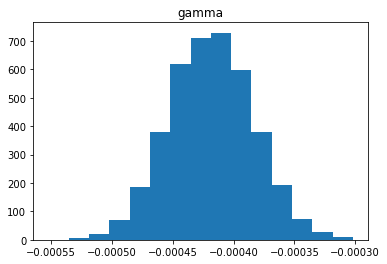

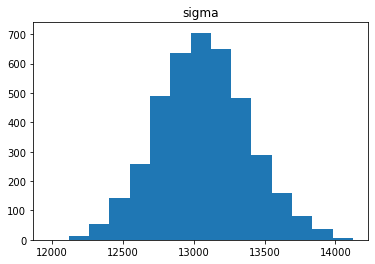

In [27]:
for var in ['beta', 'gamma', 'sigma']:
    plt.hist(fit_sq.stan_variable(var), bins=15)
    plt.title(var)
    plt.show()

In [37]:
fit_sq.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-4800.00000,2.500000e-02,1.200000,-4800.00000,-4800.00000,-4800.00000,2200.0,150.0,1.0
beta,11.00000,4.400000e-03,0.230000,11.00000,11.00000,11.00000,2700.0,190.0,1.0
gamma,-0.00042,6.600000e-07,0.000034,-0.00048,-0.00042,-0.00036,2700.0,190.0,1.0
sigma,13000.00000,5.400000e+00,310.000000,13000.00000,13000.00000,14000.00000,3300.0,230.0,1.0
mu[1],4305.00000,1.700000e+00,90.000000,4160.00000,4304.00000,4455.00000,2842.0,201.0,1.0
...,...,...,...,...,...,...,...,...,...
y_hat[469],59077.00000,2.060000e+02,13271.000000,37238.00000,59049.00000,81206.00000,4140.0,293.0,1.0
y_hat[470],59532.00000,2.000000e+02,13011.000000,38374.00000,59640.00000,80569.00000,4237.0,300.0,1.0
y_hat[471],61821.00000,2.110000e+02,13215.000000,40143.00000,61805.00000,83450.00000,3920.0,277.0,1.0


Here again we see that the posterior is in line with real data

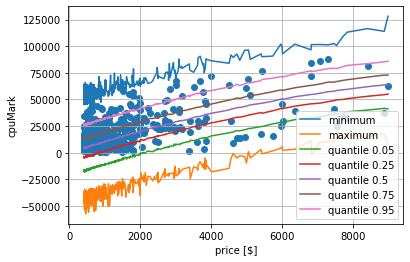

In [48]:
plot_quantiles(fit_sq.stan_variable('score'), data['price'])
plt.scatter(data['price'], data['cpuMark'])
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.grid()

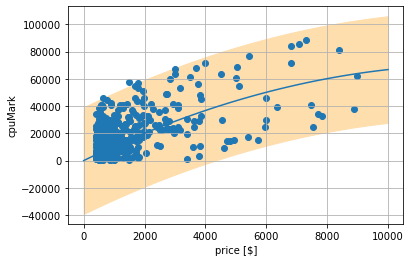

In [49]:
x_lim = np.array([0, 10000])
beta = np.mean(fit_sq.stan_variable('beta'))
gamma = np.mean(fit_sq.stan_variable('gamma'))
sigma = np.mean(fit_sq.stan_variable('sigma'))
x = np.linspace(0, 10000, 100)
y = beta * x + gamma * np.square(x)
plt.plot(x, y)
plt.fill_between(x, y+3*sigma, y-3*sigma, color='navajowhite')
plt.grid()
plt.scatter(data['price'], data['cpuMark'])
plt.xlabel('price [$]')
plt.ylabel('cpuMark')
plt.show()

# Model comparison

It seems that the results for both criteria are nearly identical - the linear model gets a better log-score than the quaratic one, without any overlap.

One reason for this could be that the prior for the linear model was selected based on the data while the one for quadratic function was, at least for the $\gamma$ parameter provided more correctly as a prior belief. This could lead to greater overfitting in the linear model.

Another observation is that for both of the models the log-scores are very low - the models are not performing very well, at least according to the compare method. On the one hand this seems surprising because they seem to capture the real data reasonably well. On the other, the $\sigma$ parameter value is incredibely large in both of the models - so large that the models probably do have a very weak ability to predict anything. After all both of the models stop allowing CPUs with negative benchmark score at about 4000$ price, so it's probably fair to say that the models aren't very useful.

# Loo

* The linear model gets a log-score of -5141 while the quadratic -5181. 
* The linear model is the clear winner here, there is no overlap in the results.
* No warnings were issued.

C:\Users\Data\anaconda3\envs\DataAnalytics\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\Data\anaconda3\envs\DataAnalytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
C:\Users\Data\anaconda3\envs\DataAnalytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


<AxesSubplot:xlabel='Log'>

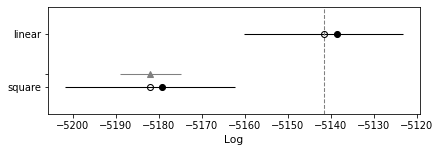

In [30]:
linear = az.from_cmdstanpy(fit, log_likelihood='log_lik', posterior_predictive='y_hat')
square = az.from_cmdstanpy(fit_sq, log_likelihood='log_lik', posterior_predictive='y_hat')
loo = az.compare({'linear': linear, 'square': square}, 'loo')
az.plot_compare(loo)


In [31]:
loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
linear,0,-5141.651688,3.167120,0.000000,1.0,18.458829,0.000000,False,log
square,1,-5181.981651,2.650177,40.329963,0.0,19.827181,7.075899,False,log


# WAIC

The results here are almost identical

* The linear model gets a log-score of -5141 while the quadratic -5181.
* The linear model is the clear winner here, there is no overlap in the results.
* No warnings were issued.

C:\Users\Data\anaconda3\envs\DataAnalytics\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\Data\anaconda3\envs\DataAnalytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
C:\Users\Data\anaconda3\envs\DataAnalytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


<AxesSubplot:xlabel='Log'>

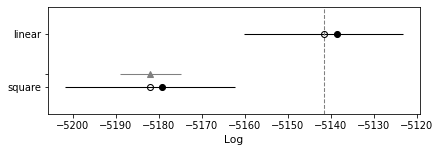

In [32]:
waic = az.compare({'linear': linear, 'square': square}, 'waic')
az.plot_compare(waic)

In [33]:
waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
linear,0,-5141.651794,3.167226,0.000000,1.0,18.458832,0.000000,False,log
square,1,-5181.979173,2.647699,40.327379,0.0,19.826959,7.076093,False,log
